In [1]:
import glob
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import os
import oscdeeppy as odp
from importlib import reload

# Image Lists

In [2]:
DTYPE = np.float32 # Not sure what int types will do; float64 is probably overkill 
BLACKPOINT_SIGMA = 2.7 # Larger tends to make darker images
SYMMETRY_SIGMA = 0.5 # offset from background peak in units of background sigma for stretching

ImageSet = odp.FITSSet

darks = glob.glob('../astro/2025_Cassiopeias_Ghost/2025-10-03_Cassiopeias_Ghost/Dark/*.fits')
flats = glob.glob('../astro/2025_Cassiopeias_Ghost/2025-10-03_Cassiopeias_Ghost/Flat/*.fits')
lights = glob.glob('../astro/2025_Cassiopeias_Ghost/2025-10-03_Cassiopeias_Ghost/Light/*.fits')
tag = 'ic63_cassiopeias_ghost'

print(len(flats),len(darks),len(lights))

50 50 149


# Calibration Data Processing

In order to image very dim objects, one requires a very sensitive and very well calibrated sensor. Data taken in contrived situations (very short exposure, lens cap on or off, pointed at uniform white surface, etc) provide footholds for calculating unknown quantities in the imaging system, like precise per-pixel sensitivity, positions of dust shadows, hot/dead pixels etc.

## Dark

Dark frames are nominally long exposure at the same gain as light frames, but with the sensor dark. These capture noise that builds with time. Helpful to have the same exposure time as light frames, but can be scaled to compensate. The ASI2600 is close enough to zero dark noise that I take darks for my flats and reuse them for the lights (same gain and offset) and ignore bias calibration (dark and bias are the same, effectively).

In [3]:
dark_set = ImageSet(darks)

In [4]:
dark_set[0]

array([[518, 505, 517, ..., 509, 533, 504],
       [509, 962, 502, ..., 975, 497, 949],
       [518, 505, 541, ..., 498, 525, 495],
       ...,
       [503, 949, 506, ..., 970, 503, 943],
       [523, 496, 524, ..., 505, 519, 499],
       [502, 945, 508, ..., 973, 503, 943]],
      shape=(4176, 6248), dtype=uint16)

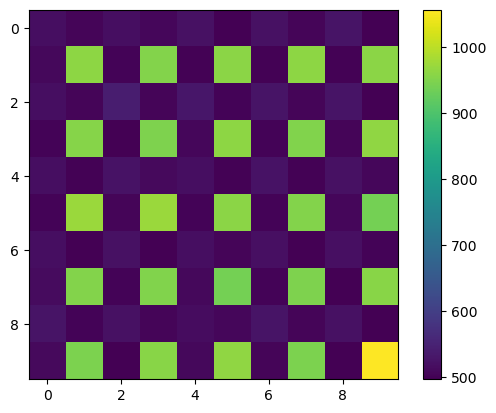

In [5]:
# Look at a subset to see the bayer pattern is in the darks
plt.imshow(dark_set[0][:10,:10])
plt.colorbar()

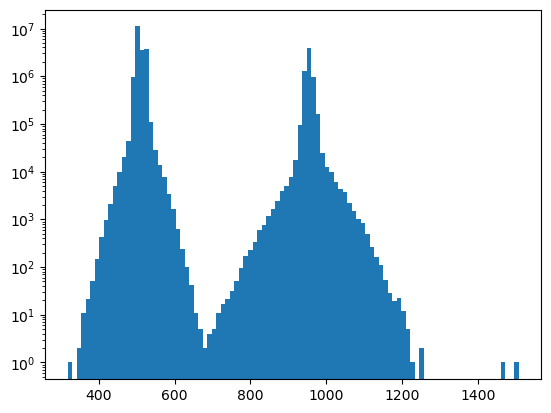

In [6]:
#Really three (two? four?) of nearly the same distribution but different tail behavior
plt.hist(dark_set[0].ravel(),bins=100)
plt.yscale('log')

### Stacking

This will read the stack images and average them with no rejection or other manipulation.

In [7]:
dark_avg = odp.simple_stack(dark_set, dtype=DTYPE, verbose=True)

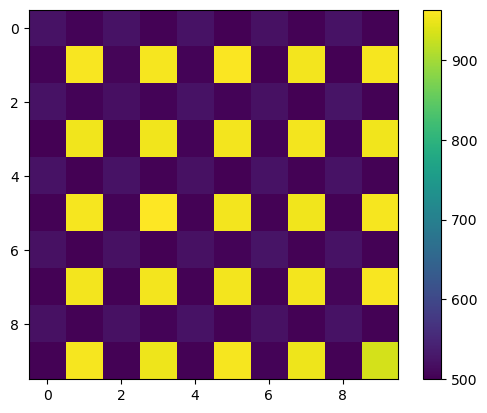

In [8]:
# Look at a subset to see the bayer pattern is in the darks
plt.imshow(dark_avg[:10,:10])
plt.colorbar()

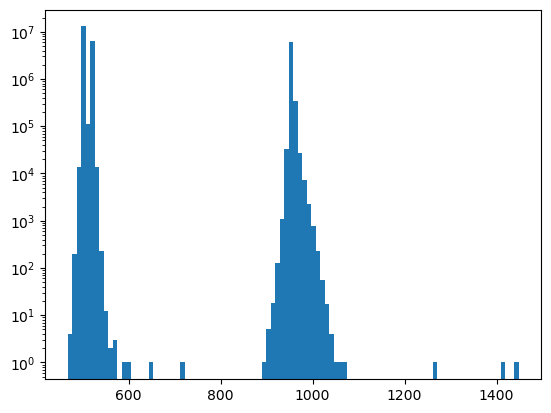

In [9]:
#Averaging kills the tails, revealing a much narrower dark/bias distribution and a few warm pixels
plt.hist(dark_avg.ravel(),bins=100)
plt.yscale('log')

### Histogram

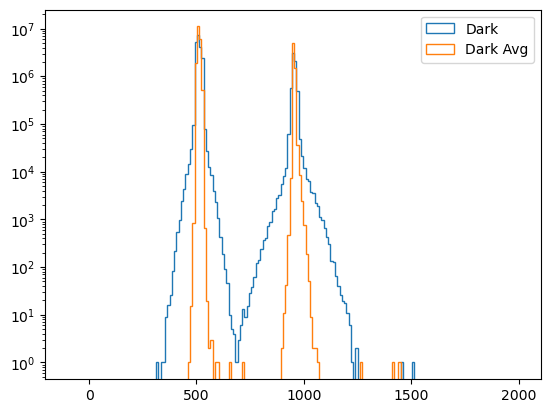

In [10]:
plt.hist(dark_set[0].ravel(), bins=np.linspace(-100,2000,200), histtype='step',label='Dark')
plt.hist(dark_avg.ravel(), bins=np.linspace(-100,2000,200), histtype='step',label='Dark Avg')
plt.yscale('log')
plt.legend()

## Flat

Flats capture nonuniform response to light in the optical system due to imperfections in the telescope/lens, dust on the sensor, or senor response itself. This corrects for effects similar to vignetting as well. Raw flats should be offset corrected with bias/darks. Flats are then normalized so that the multiplicative effect does not modify the mean intensity of a uniform image.

In [11]:
flat_set = ImageSet(flats)

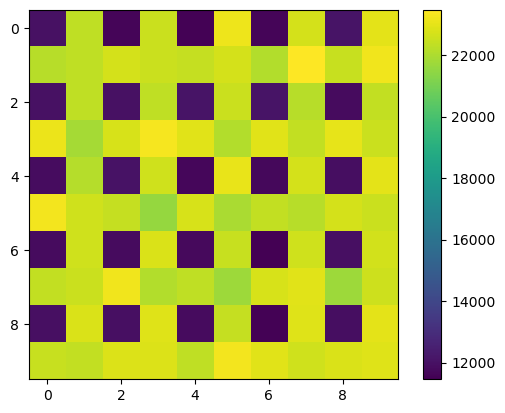

In [12]:
# Look at a subset to see the bayer pattern is in the flats
plt.imshow(flat_set[0][:10,:10])
plt.colorbar()

### Dark Subtraction

In [13]:
def dark_subtact(img, dark):
    ''' 
    This is an image sequence transformation. 
    Images in the sequence will be passed to the first argument by an ImageProcessor
    Any number of additional static arguments can be passed.
    '''
    return img - dark

In [14]:
#This is how to create an empty image sequence
flat_calib_set = odp.DiskSet('flat_calib.apy',recreate=True, dtype=DTYPE, num_img=len(flat_set), img_shape=flat_set.img_shape)

#And here is how to efficiently (multiprocessing) fill it with the result of an operation (dark_subtract) 
#using map() syntax over the flat_set, and specifying and output_set to contain the per-image results
with odp.ImageProcessor(nproc=16) as proc:
    proc.map(dark_subtact, flat_set, args=(dark_avg,), output_set=flat_calib_set, verbose=True)

100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


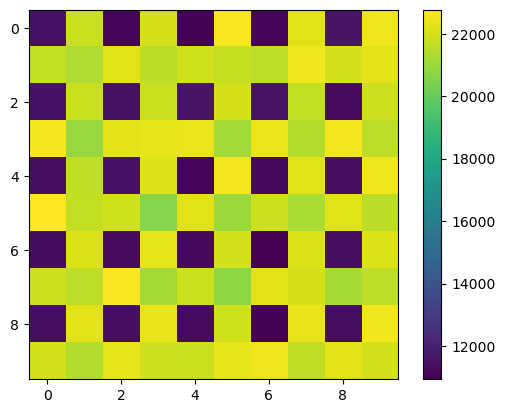

In [15]:
# Look at a subset to see the bayer pattern is in the calibrated flats
plt.imshow(flat_calib_set[0][:10,:10])
plt.colorbar()

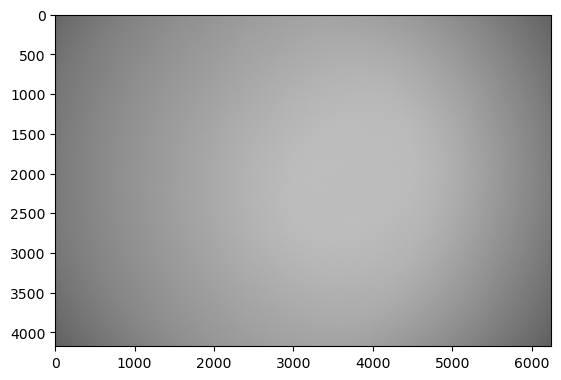

In [16]:
odp.display_rgb(flat_calib_set[0])

### Stacking

In [17]:
flat_avg = odp.simple_stack(flat_calib_set, dtype=DTYPE, verbose=True)

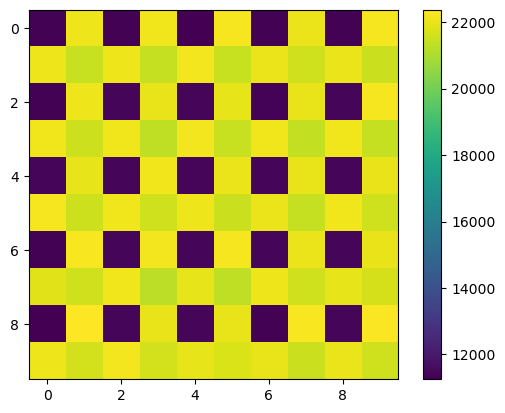

In [18]:
# Look at a subset to see the bayer pattern is in the calibrated flats
plt.imshow(flat_avg[:10,:10])
plt.colorbar()

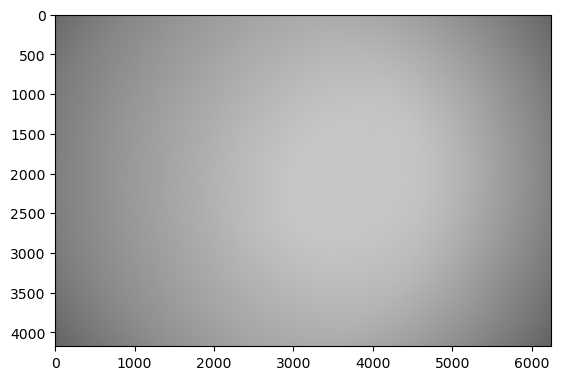

In [19]:
odp.display_rgb(flat_avg)

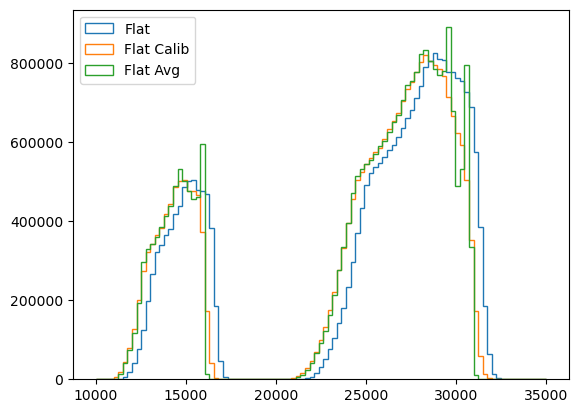

In [20]:
plt.hist(flat_set[0].ravel(), bins=np.linspace(10000,35000,100), histtype='step',label='Flat')
plt.hist(flat_calib_set[0].ravel(), bins=np.linspace(10000,35000,100), histtype='step',label='Flat Calib')
plt.hist(flat_avg.ravel(), bins=np.linspace(10000,35000,100), histtype='step',label='Flat Avg')
plt.legend()

### Normalization

Normalization is twofold: equalize color channels and make overall scale factor average to unity.

In [21]:
R,G1,G2,B = odp.debayer_simple(flat_avg, channels=True)

flat_norm = odp.rebayer_simple(R/R.mean(),G1/G1.mean(),G2/G2.mean(),B/B.mean())

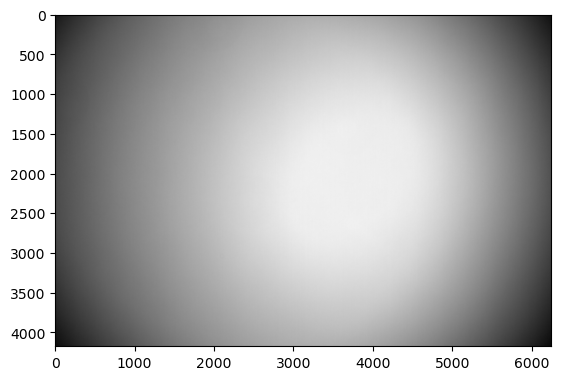

In [22]:
odp.display_rgb(flat_norm)

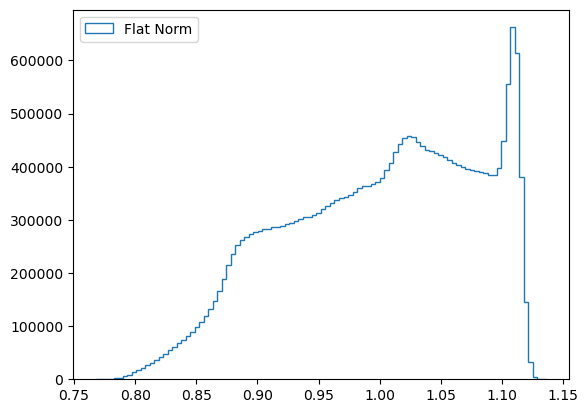

In [23]:
#That really cleans up the flat histogram! This shape surely has something to do with the optics
plt.hist(flat_norm.ravel(), bins=100, histtype='step',label='Flat Norm')
plt.legend()

# Light Image Processing

This is the real data. It needs to be calibrated, followed by a star detection step and identification of alignment transformations. Only then can the images be successfully stacked.

In [24]:
light_set = ImageSet(lights)

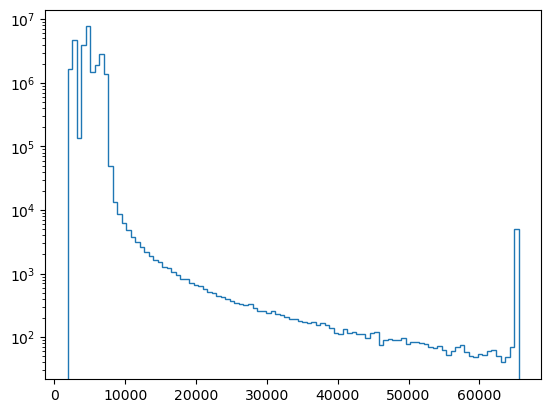

In [25]:
#AHHH REAL DATA
plt.hist(light_set[0].ravel(), bins=100, histtype='step')
plt.yscale('log')

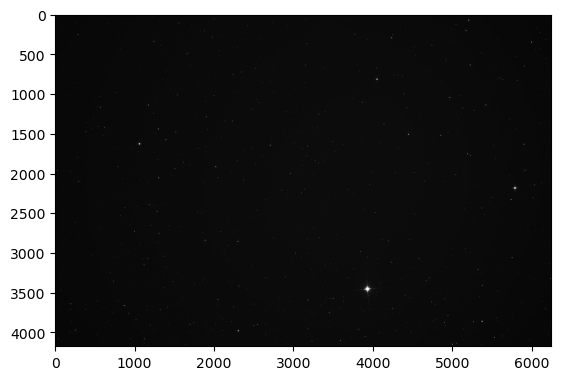

In [26]:
# It's linear, so not much to see
odp.display_rgb(light_set[0])

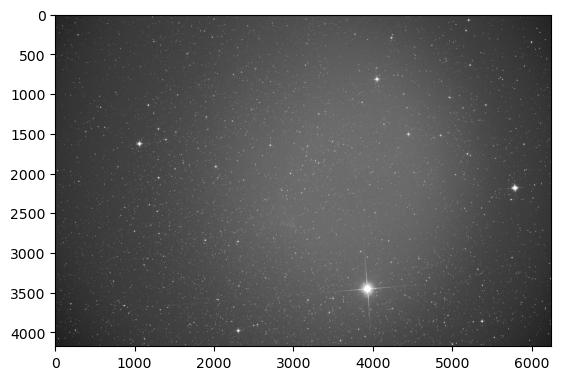

In [27]:
# But, it's easy to apply some autoscaling 
odp.display_rgb(light_set[0], scale='auto')

## Dark & Flat Calibration

In [28]:
dark_master = dark_avg
flat_master = flat_norm

def calibrate_light_img(img):
    '''
    This is another sequence transformation, doing both dark and flat calibration
    Arguments are optional, closures work just fine. 
    '''
    return (img - dark_master) / flat_master

In [29]:
light_calib_set = odp.DiskSet('light_calib.apy',recreate=True, dtype=DTYPE, num_img=len(light_set), img_shape=light_set.img_shape)

with odp.ImageProcessor(nproc=16) as proc:
    proc.map(calibrate_light_img, light_set, output_set=light_calib_set, verbose=True)

100%|█████████████████████████████████████████| 149/149 [00:17<00:00,  8.54it/s]


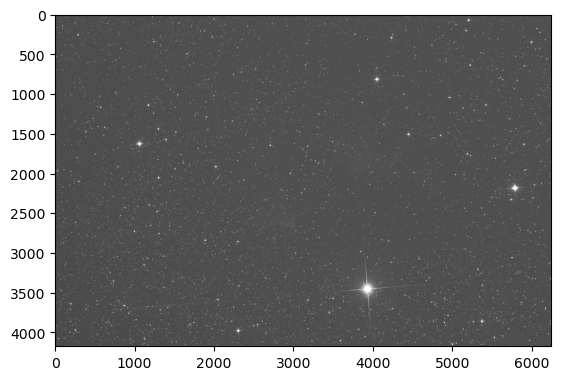

In [30]:
# The flat and dark calibration has now produced nicely calibrated light frames
odp.display_rgb(light_calib_set[0], scale='auto')

## Find Stars

Stars are the reference points for alignment, and also provide a lot of good information about the quality of the image with their shape and size. This code will identify the 250 brightest stars that meet some basic criteria of not being too distorted or clipping.

In [31]:
def star_finder(img, **kwargs):
    '''
    This is another image sequence transformation.
    Unlike the others, this does not return an image, but rather information about identified stars.
    find_stars could be used directly on an RGB image, but we debayer on the fly here and use the green channel (default).
    '''
    return odp.find_stars(odp.debayer_full(img), **kwargs)

Fit(2223): Optimization terminated successfully.
FWHM 94.60829157699173 ECC 0.9243105083537546 SNR 7.4280125620819275 LVL 176725.20943698756 DIST 81.51782938618882
Candidate Excluded
Fit(2549): Optimization terminated successfully.
FWHM 352.7997606663294 ECC 0.9735060736921637 SNR 1.6671799897945756 LVL 605107.8988781058 DIST 217.95624021787566
Candidate Excluded
Fit(1444): Optimization terminated successfully.
FWHM 81.49299204555922 ECC 0.7880813289197582 SNR 2.968929676882172 LVL 118556.8371681892 DIST 32.376922372648224
Candidate Excluded
Fit(1585): Optimization terminated successfully.
FWHM 55.18577593619864 ECC 0.8227723766521933 SNR 48.62593983360233 LVL 71296.7041332675 DIST 19.321904552334296
Candidate Excluded
Fit(1077): Optimization terminated successfully.
FWHM 52.08975542312315 ECC 0.8984468300035965 SNR 14.431269648359855 LVL 63876.03653561639 DIST 19.24236931275395
Candidate Excluded
Fit(411): Optimization terminated successfully.
FWHM 19.71605227333381 ECC 0.402425826687

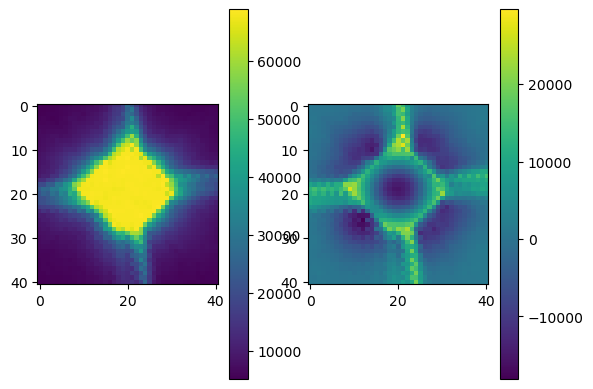

array([[5.79395526e+03, 2.18797757e+03, 1.97160523e+01, 7.92171172e+04,
        4.35668565e+03, 4.02425827e-01]])

In [32]:
star_finder(light_calib_set[0], patch_radius=20, snr_min=5, num_stars=1, verbose=True) # For a demo

In [33]:
# Image transformations that have non-image results can simply return them. 
# kwargs not known to map are passed through

with odp.ImageProcessor(nproc=16) as proc:
    reg_stars = proc.map(star_finder, light_calib_set, num_stars=250, patch_radius=20, snr_min=5, verbose=True)

100%|█████████████████████████████████████████| 149/149 [04:51<00:00,  1.96s/it]


Image 0 FWHM 4.772 ECC 0.538


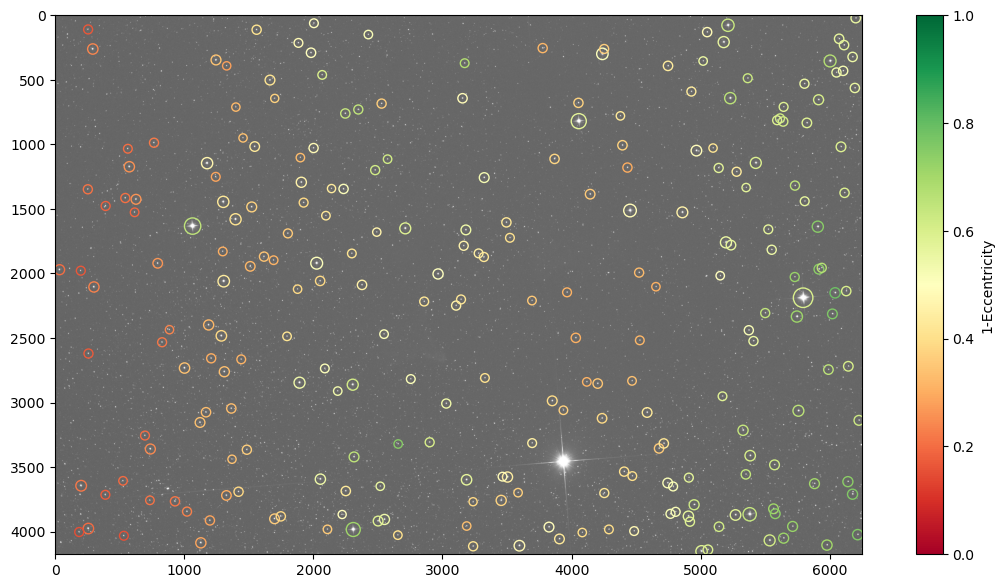

In [34]:
from matplotlib import colormaps
cmap = colormaps['RdYlGn']

for i,(img,stars) in enumerate(zip(light_calib_set,reg_stars)):
    print(f'Image {i} FWHM {np.mean(stars[:,2]):0.3f} ECC {np.mean(stars[:,5]):0.3f}')
    plt.figure(figsize=[14,7])
    odp.display_rgb(img,scale='linear',clip_sigmas=5)
    sc = plt.scatter(stars[:,0], stars[:,1], s=10*stars[:,2], fc='none', ec=cmap(1.0-stars[:,5]))
    plt.colorbar(sc,label='1-Eccentricity')
    sc.set_cmap(cmap)
    sc.set_clim(0,1)
    plt.show()
    plt.close()
    break

## Find Constellations

Image alignment has a huge search space. It helps immensely if there's a quick way to identify the rough offset and orientation of the images before throwing the problem to a least-squares minimization routine. To achieve that, I leverage the fact that triangles have a hashable representation that is position and rotation invariant in the tuple of side lengths ordered greatest to least. Generating triangles from nearby stars in two images and putting those triangles' ordered side lengths into a KD-tree allowed to efficient checking for matching triangles in two images, with each pair capable of giving the relative orientation. 

In [35]:
with mp.Pool(16) as pool:
    reg_consts = pool.map(odp.build_constellations,reg_stars)

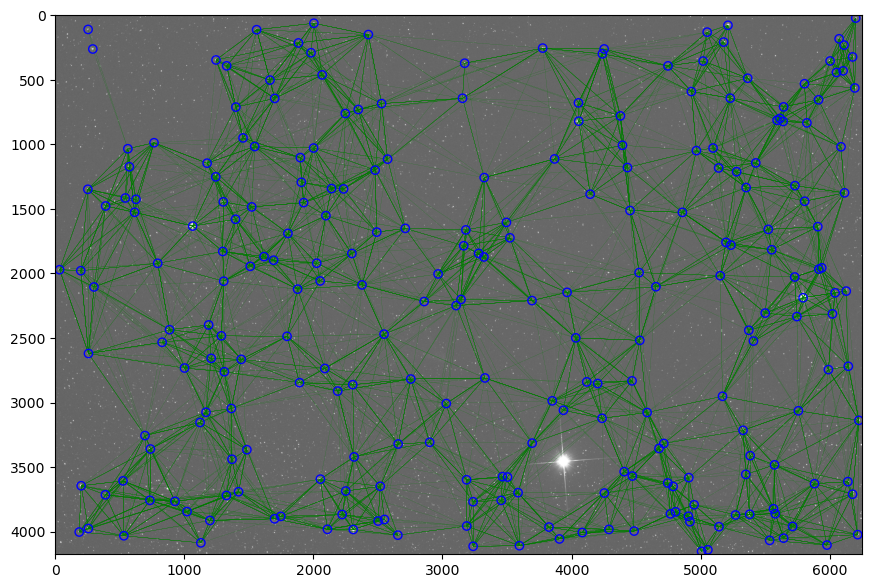

In [36]:
for i,(img,stars,tris) in enumerate(zip(light_calib_set,reg_stars,reg_consts)):
    plt.figure(figsize=[14,7])
    odp.display_rgb(img,scale='linear',clip_sigmas=5)
    odp.draw_constellations(tris, color='g', alpha=1.0, linewidth=0.1)
    plt.scatter(stars[:,0], stars[:,1], fc='none', ec='b')
    plt.show()
    plt.close()
    break

## Find Alignment Transformations

Find the matching triangles, generate positions of matching stars in both images, and then find a transformation that aligns one to the other.

In [37]:
ref_idx = 0

import itertools
import functools

class ref_skip:
    '''For a starmap operation, this can wrap a function to skip processing a specific index and return 
       a fixed value (usually None) instead. Assumes whatever you would have iterated over with the bare 
       function is instead wrapped in enumerate'''
    
    def __init__(self, f, ref_idx, ref_val=None):
        self.f = f
        self.ref_idx = ref_idx
        self.ref_val = ref_val
        
    def __call__(self, i, args, **kwargs):
        if i == self.ref_idx:
            return self.ref_val
        else:
            return self.f(*args, **kwargs)

ft = functools.partial(odp.find_transformation, max_iter=10)

with mp.Pool(16) as pool:
    const_pairs = pool.starmap(ref_skip(odp.find_corresponding_constellations,ref_idx), enumerate(zip(itertools.repeat(reg_consts[ref_idx]),reg_consts)))
    star_pairs = pool.starmap(ref_skip(odp.find_corresponding_points,ref_idx), enumerate(const_pairs))
    fit_txs = pool.starmap(ref_skip(ft,ref_idx), enumerate(star_pairs))

Image 1
          message: Optimization terminated successfully.
          success: True
           status: 0
              fun: 0.1250501505194863
                x: [-1.033e+01  1.360e+01 -6.169e-05]
              nit: 5
            direc: [[ 5.568e-02 -1.681e-01 -2.963e-05]
                    [ 0.000e+00  0.000e+00  1.000e+00]
                    [ 4.275e-03 -1.190e-03 -6.348e-07]]
             nfev: 227
 average_distance: 0.1250501505194863
      total_stars: 222
        star_mask: [ True False ...  True  True]


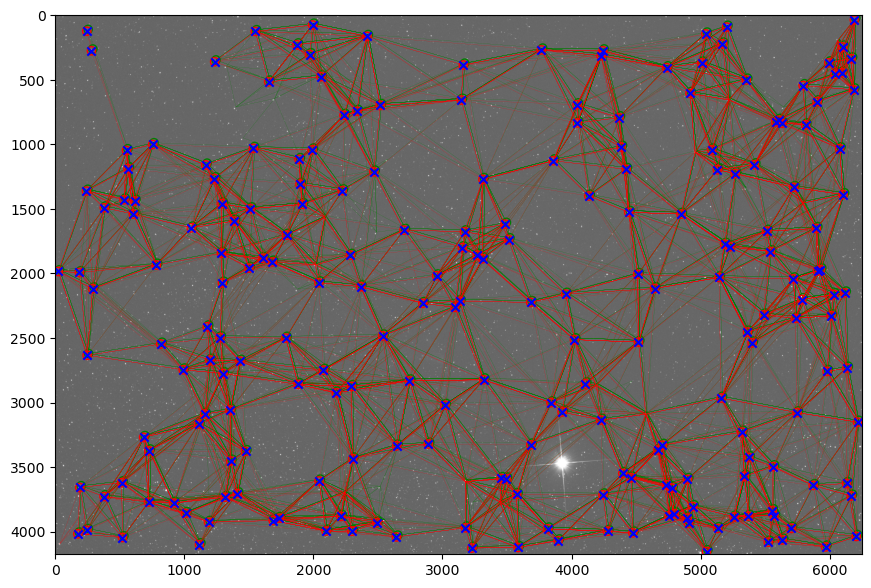

Image 2
          message: Optimization terminated successfully.
          success: True
           status: 0
              fun: 0.473401195757735
                x: [ 6.992e+01  1.010e+02  8.711e-04]
              nit: 5
            direc: [[ 1.000e+00  0.000e+00  0.000e+00]
                    [-1.187e+00  2.197e+00  4.588e-04]
                    [-3.865e-02 -8.800e-04  1.068e-05]]
             nfev: 195
 average_distance: 0.473401195757735
      total_stars: 208
        star_mask: [ True  True ... False  True]


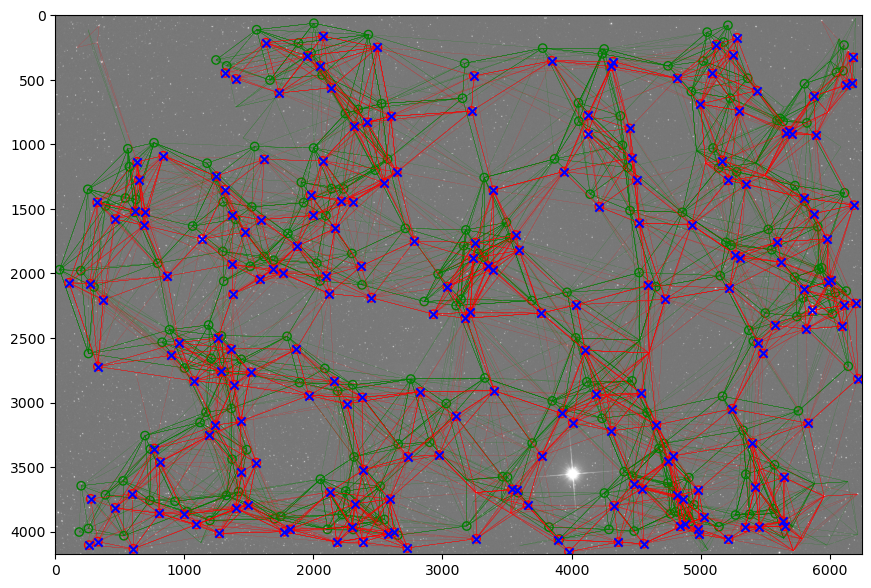

In [38]:
for i,(img,stars,tris,fit) in enumerate(zip(light_calib_set,star_pairs,const_pairs,fit_txs)):
    if ref_idx == i:
        continue
    print(f'Image {i}')
    
    print(fit)
    plt.figure(figsize=[14,7])
    odp.display_rgb(img,scale='linear',clip_sigmas=5)
    stars_a,stars_b,mean_rot,mean_tx = stars
    tris_a,tris_b = tris
    odp.draw_constellations(tris_a, color='g', alpha=1.0, linewidth=0.1)
    plt.scatter(stars_a[fit.star_mask,0], stars_a[fit.star_mask,1], fc='none', ec='g')
    odp.draw_constellations(tris_b, color='r', alpha=1.0, linewidth=0.1)
    plt.scatter(stars_b[fit.star_mask,0], stars_b[fit.star_mask,1], fc='none', ec='r')
    stars_a_tx = odp.transform_coords(stars_a[fit.star_mask,:2],*fit.x)
    plt.scatter(stars_a_tx[:,0], stars_a_tx[:,1], c='b', marker='x')
    plt.show()
    plt.close()
    if i >= 2: break

## Image Selection

Based on metrics determined during star finding and alignment.

Text(0.5, 0, 'eccentricity')

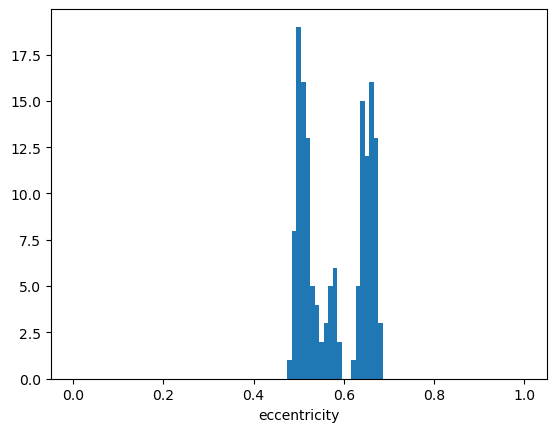

In [39]:
eccentricity = np.asarray([np.mean(star[:,5]) for star in reg_stars])
plt.hist(eccentricity,bins=np.linspace(0,1,100))
plt.xlabel('eccentricity')

Text(0.5, 0, 'fwhm')

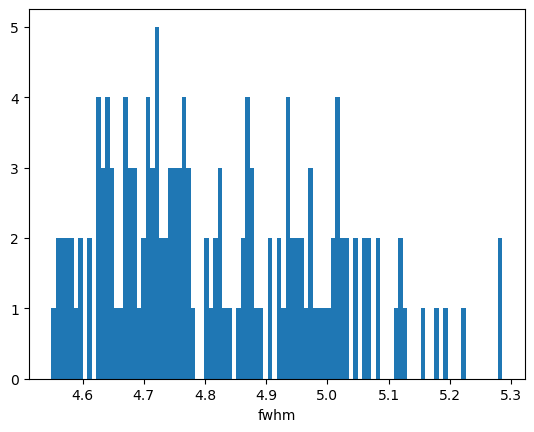

In [40]:
fwhm = np.asarray([np.mean(star[:,2]) for star in reg_stars])
plt.hist(np.clip([np.mean(star[:,2]) for star in reg_stars],0,10),bins=100)
plt.xlabel('fwhm')

Text(0.5, 0, 'total stars')

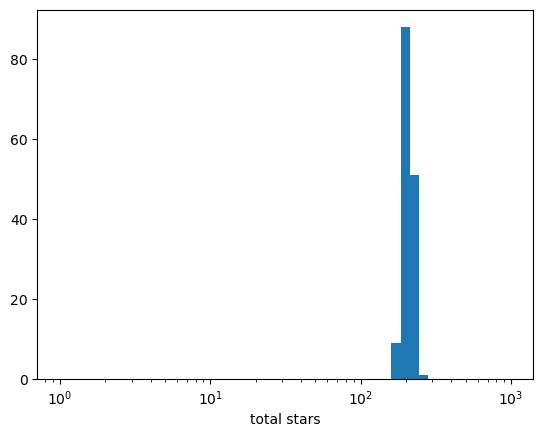

In [41]:
total_stars = np.asarray([fit.total_stars if fit else len(reg_stars[ref_idx]) for fit in fit_txs ])
plt.hist(total_stars,bins=np.logspace(0,3))
plt.xscale('log')
plt.xlabel('total stars')

Text(0.5, 0, 'average tx distance')

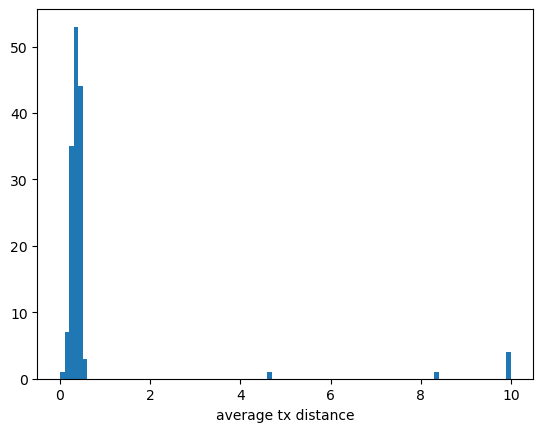

In [42]:
avg_dist = np.asarray([fit.average_distance if fit else 0.0 for fit in fit_txs ])
plt.hist(np.clip(avg_dist,0,10),bins=100)
plt.xlabel('average tx distance')

[ True  True  True  True  True  True  True False  True  True False  True
  True  True False  True  True False  True False  True False  True  True
  True False  True  True False  True  True  True False  True  True  True
  True  True  True  True  True  True False  True  True  True False  True
 False  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
  True  True  True False  True]
Total Lights: 149; Lights Used: 125
Rejected 7: FWHM 5.17888384796324 ECC 0.6477994829192947

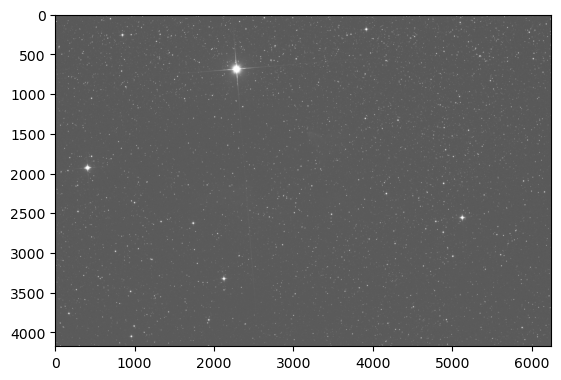

Rejected 10: FWHM 5.121756615541812 ECC 0.6715518731148443 TOT 203 DIST 0.23492642842977088


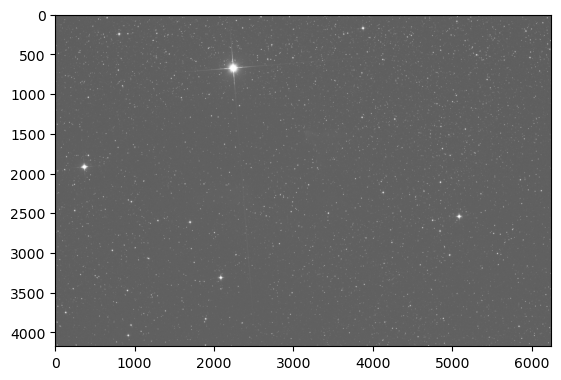

Rejected 14: FWHM 5.285449506931245 ECC 0.6352939091689737 TOT 203 DIST 0.42718369886021185


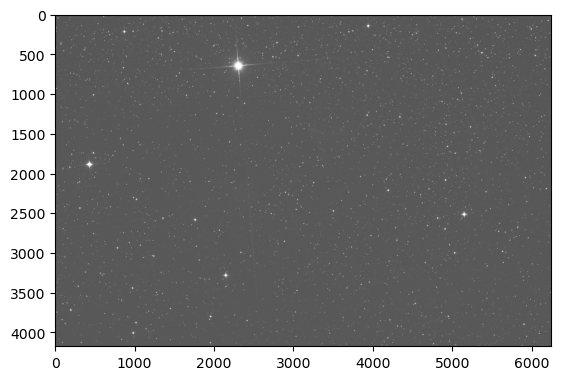

Rejected 17: FWHM 4.956143122797379 ECC 0.6400992062626074 TOT 196 DIST 32.119232399858255


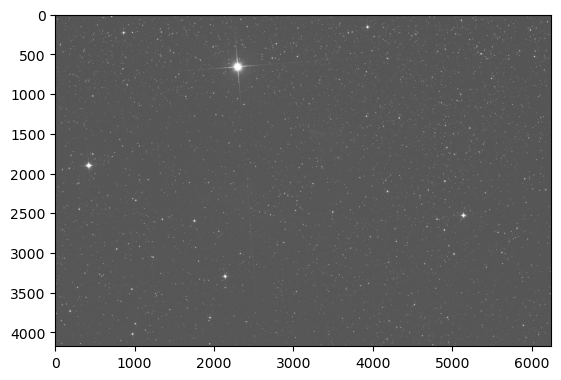

Rejected 19: FWHM 5.222247444561352 ECC 0.6408041139304048 TOT 208 DIST 0.2936190592824273


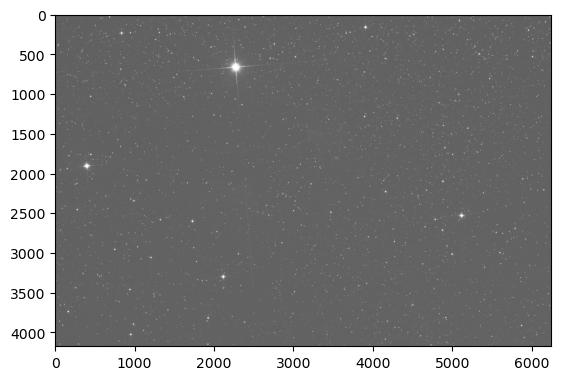

Rejected 21: FWHM 5.059636729647051 ECC 0.6260235366577521 TOT 203 DIST 0.39411304909824096


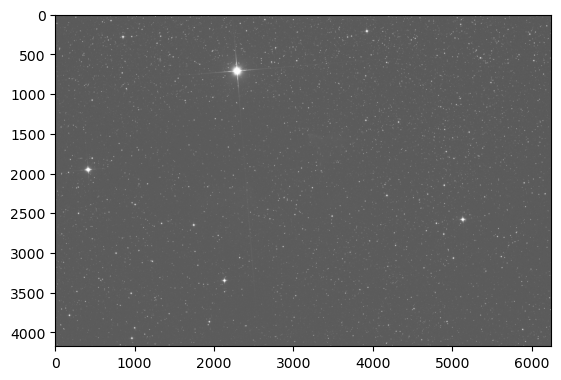

Rejected 25: FWHM 5.157451953308376 ECC 0.6521494314645131 TOT 199 DIST 0.37291368158901184


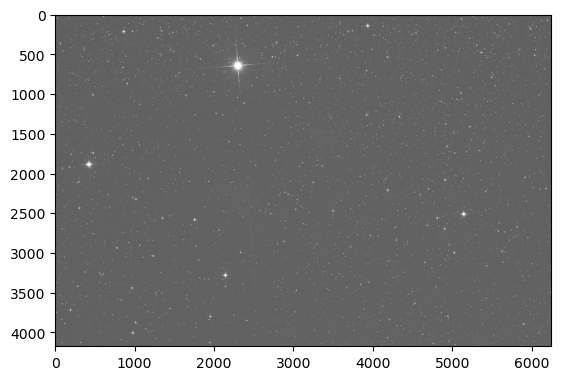

Rejected 28: FWHM 4.6122795641487935 ECC 0.5702761413582078 TOT 218 DIST 13.719382942611777


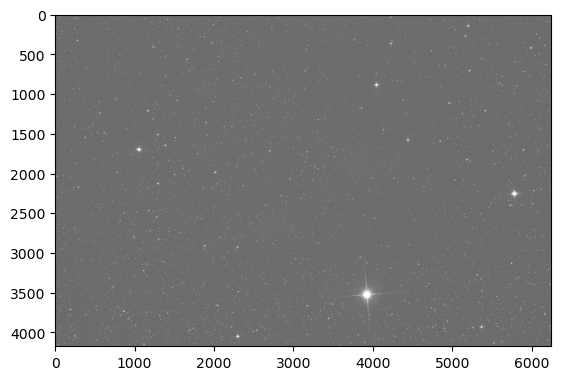

Rejected 32: FWHM 5.031805677986386 ECC 0.6415272642556938 TOT 183 DIST 0.41319847141268323


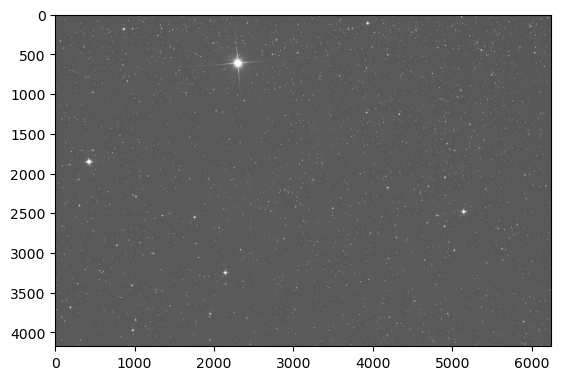

Rejected 42: FWHM 4.932709412978574 ECC 0.6586656407216973 TOT 197 DIST 17.41335318322673


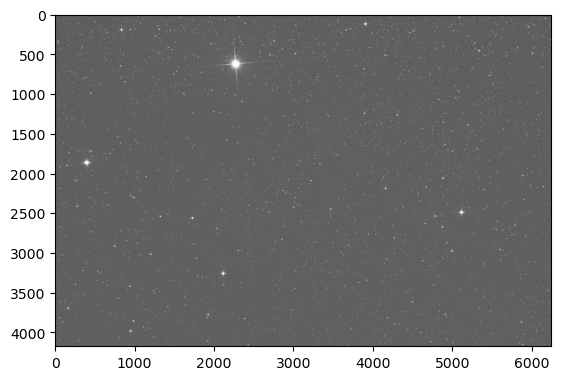

Rejected 46: FWHM 5.120073242305438 ECC 0.6397722045121845 TOT 194 DIST 0.4645472579993671


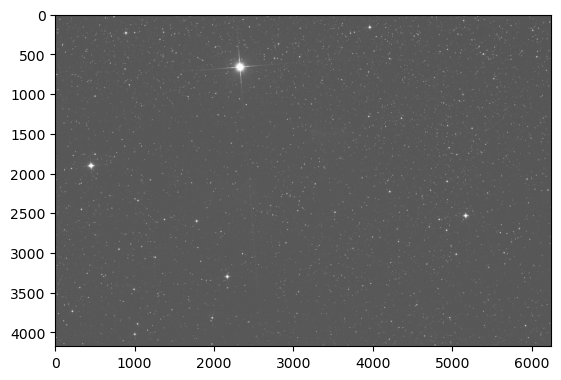

Rejected 48: FWHM 4.671787712417926 ECC 0.5188739632010181 TOT 216 DIST 28.673600217535355


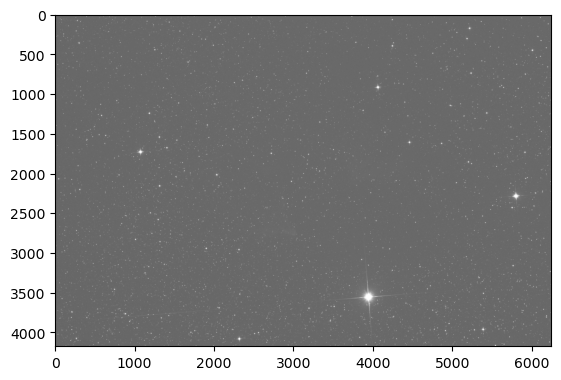

Rejected 51: FWHM 5.066632086804042 ECC 0.6463989389937371 TOT 188 DIST 0.43113804302397507


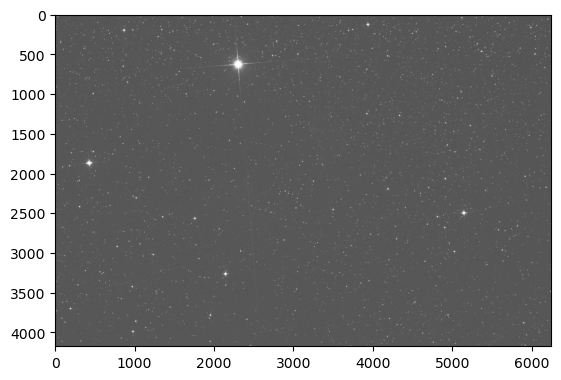

Rejected 52: FWHM 5.069119922552683 ECC 0.6301960402528549 TOT 198 DIST 0.2992697636781254


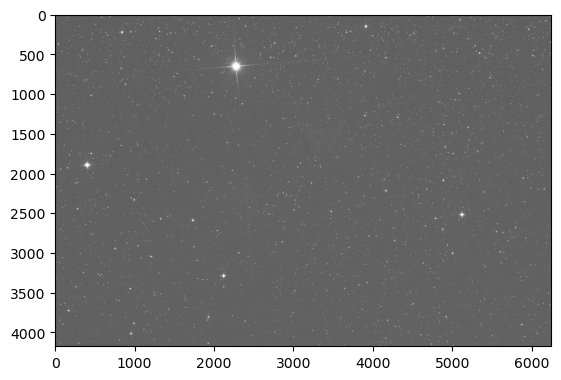

Rejected 67: FWHM 5.058169787170809 ECC 0.6414711818319981 TOT 197 DIST 0.39900490825945184


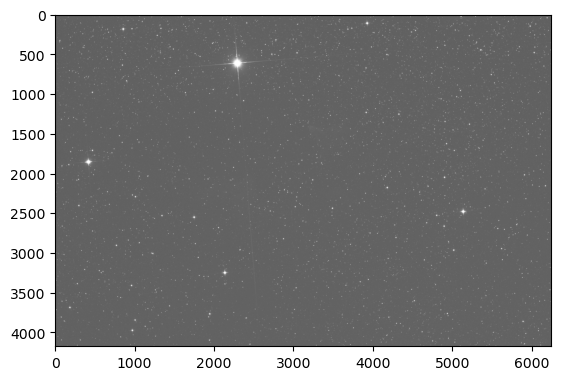

Rejected 74: FWHM 4.768717314451187 ECC 0.498283927852549 TOT 210 DIST 8.325147331032271


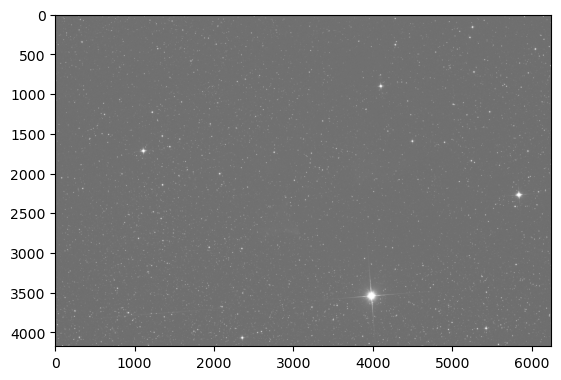

Rejected 75: FWHM 5.189872292807406 ECC 0.6317559977248691 TOT 207 DIST 0.33631076213879657


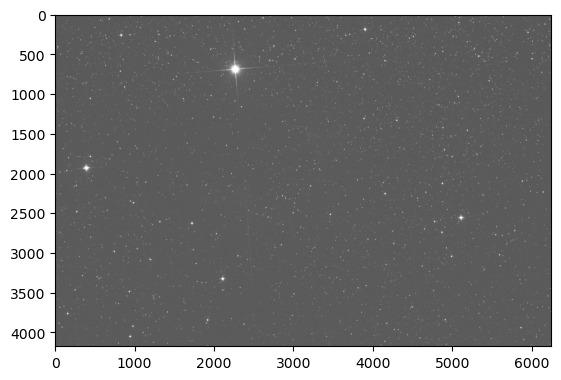

Rejected 93: FWHM 5.045537446453465 ECC 0.6585880480395506 TOT 192 DIST 0.31395568956710945


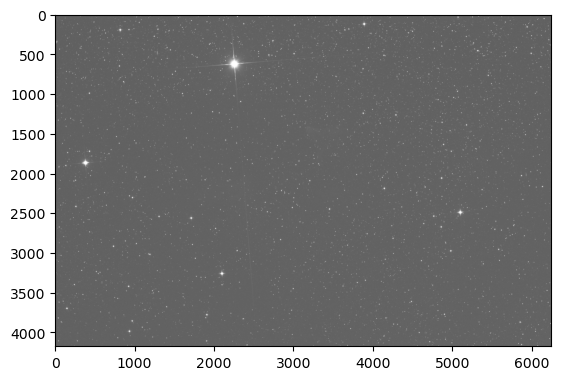

Rejected 109: FWHM 5.285514367002385 ECC 0.62985200085362 TOT 199 DIST 0.33658239519248206


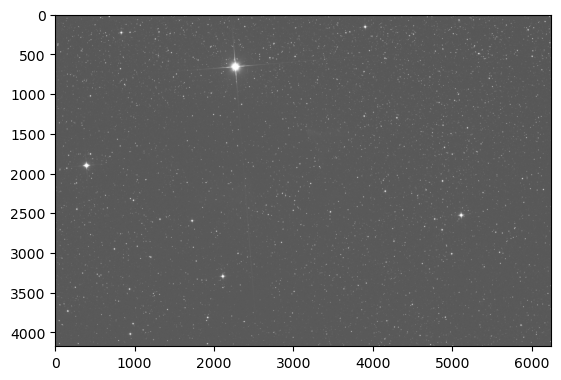

Rejected 119: FWHM 5.084051142331844 ECC 0.6499763606169324 TOT 194 DIST 0.4009287498479703


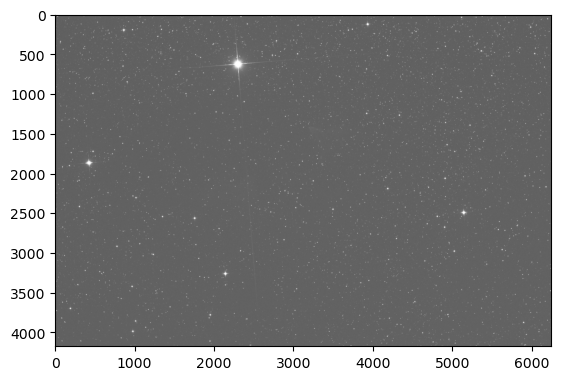

Rejected 124: FWHM 5.115930282811524 ECC 0.6305109749489016 TOT 169 DIST 0.4780125629609052


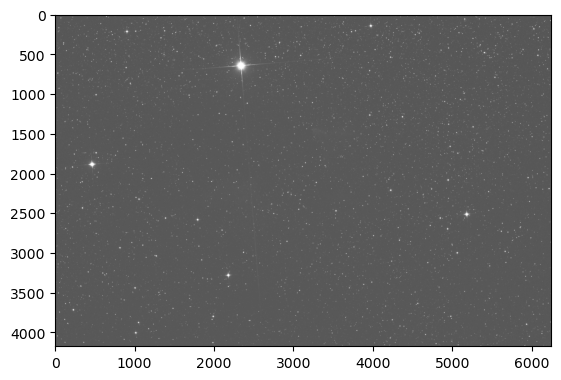

Rejected 136: FWHM 5.124071548031969 ECC 0.6721820307709856 TOT 201 DIST 0.25575604978637817


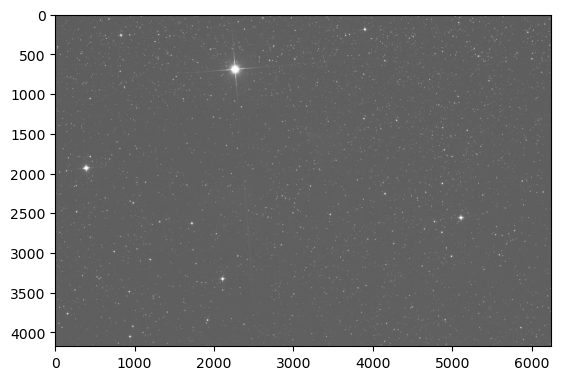

Rejected 139: FWHM 5.083755800020484 ECC 0.6498111780776846 TOT 208 DIST 0.33051482626668094


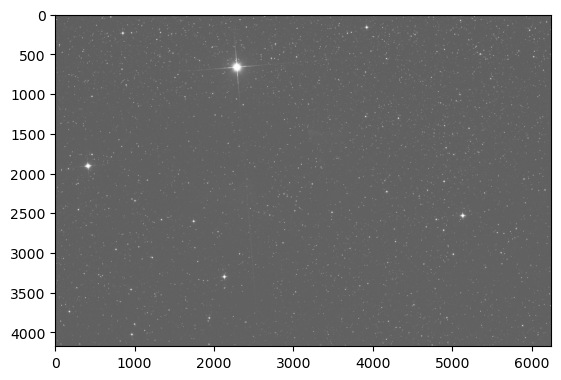

Rejected 147: FWHM 5.044704588168307 ECC 0.6727442943326702 TOT 193 DIST 0.255958880621597


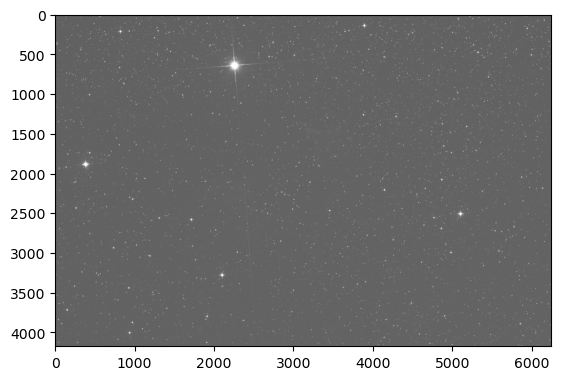

In [43]:
def median_sigma_cut(values, sigmas, **kwargs):
    m,s = np.median(values, **kwargs),np.std(values, **kwargs)
    return np.abs(values - m) < sigmas*s

def median_sigma_max_cut(values, sigmas, **kwargs):
    m,s = np.median(values, **kwargs),np.std(values, **kwargs)
    return values - m < sigmas*s
    
def median_sigma_min_cut(values, sigmas, **kwargs):
    m,s = np.median(values, **kwargs),np.std(values, **kwargs)
    return m - values < sigmas*s

star_selection = median_sigma_max_cut(fwhm, 1.5) & median_sigma_min_cut(eccentricity, 1.5)
fit_selection = (total_stars >= 10) & median_sigma_max_cut(avg_dist, 2)
selection = star_selection & fit_selection
print(selection)
print(f'Total Lights: {len(selection)}; Lights Used: {np.count_nonzero(selection)}')
j = 0
for i,sel in enumerate(selection):
    if not sel:
        print(f'Rejected {i}: FWHM {fwhm[i]} ECC {eccentricity[i]} TOT {total_stars[i]} DIST {avg_dist[i]}')
        odp.display_rgb(light_calib_set[i],scale='linear',clip_sigmas=5)
        plt.show()
        plt.close()
        j += 1
        if j >= 5: break;

## Transform Images

Here there's a decision: keep track of the bayer matrix somehow after transforming the underlying pixel array, or simply debayer and do a bilinear interpolation to transform. Haven't implemented the former.

In [44]:
transformed_shape = light_calib_set.img_shape + (3,)

light_regtx = odp.DiskSet('light_calib_reg.apy', recreate=True, dtype=DTYPE, num_img=np.count_nonzero(selection), img_shape=transformed_shape)
print(len(light_regtx), light_regtx.img_shape)

def debayer_and_transform(img, fit_tx, **kwargs):
    return odp.image_transform_chunked(odp.debayer_full(img), fit_tx, drizzle=False, **kwargs)

# We can skip images with a selection mask and iterate over other arguments along with the set!
with odp.ImageProcessor(nproc=16) as proc:
    proc.map(debayer_and_transform, light_calib_set, fit_txs, output_set=light_regtx, selection=selection, verbose=True)

125 (4176, 6248, 3)


100%|█████████████████████████████████████████| 125/125 [01:41<00:00,  1.23it/s]


# ImageMM

After reading this https://arxiv.org/pdf/2501.03002 its clear that maximum likeihood extraction on the image set is the way to go. I'll start with my registered and transformed images with no drizzle so everthing is aligned to the same pixel grid.

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
gauss_residual_fn = odp.gauss_residual_fn
gauss_profile = odp.gauss_profile

def find_stars(img, registration_channel=1, num_stars=250, patch_radius=10, verbose=False, 
               snr_min=10, max_peak_dist=2, min_fwhm=2, max_eccentricity=0.85, clip_cut=None,
               max_attempts=2000):
    reg_ch = img[...,registration_channel] if registration_channel else img #None -> grayscale
    mean = np.mean(reg_ch)
    std = np.std(reg_ch)
    ch_max = np.max(reg_ch)

    reg_mask = np.zeros_like(reg_ch)
    shift = reg_ch-mean
    reg_mask[reg_ch > mean+std*3] = 1

    reg_blur = reg_mask
    for stage in range(2):
        reg_blur = gaussian_filter(reg_blur, sigma=3)
        
    reg_search = reg_blur.copy()

    attempts = 0
    candidate_stars = []

    i = 0
    while i < num_stars:
        idx = np.argmax(reg_search)
        x_max = idx%reg_search.shape[1]
        y_max = idx//reg_search.shape[1]
        if attempts >= max_attempts or reg_search[y_max,x_max] <= 0.0:
            print(f'Only {i} of {num_stars} requested stars from {attempts} attempts')
            break
        #print(x_max,y_max,reg_search[y_max,x_max])

        if x_max - patch_radius >= 0 and x_max + patch_radius < reg_search.shape[1] and y_max - patch_radius >= 0 and y_max + patch_radius < reg_search.shape[0]:
            reg_search[
                (y_max-patch_radius):(y_max+patch_radius+1),
                (x_max-patch_radius):(x_max+patch_radius+1)
            ] = 0 # zero out candidate region to skip in the future

            patch = reg_ch[(y_max-patch_radius):(y_max+patch_radius+1),(x_max-patch_radius):(x_max+patch_radius+1)]
            patch_max = np.max(patch)
            if patch_max/np.min(patch[patch>0]) < snr_min:
                continue # skip candidate as SNR too low to make the cut
            if clip_cut and patch_max > ch_max*clip_cut:
                continue # skip because there's clipping
                
            y = np.arange(y_max-patch_radius,y_max+patch_radius+1)
            x = np.arange(x_max-patch_radius,x_max+patch_radius+1)
            x,y = np.meshgrid(x,y)
            
            # fit the star profile
            fit = minimize(
                gauss_residual_fn(x,y,patch), 
                (x_max,y_max,2,2,0,np.max(patch),np.mean(patch)), 
                method='Powell'
            )

            attempts += 1

            mean_x, mean_y, sig_x, sig_y, theta, star_lvl, bkg_lvl = fit.x
            sig_x,sig_y = abs(sig_x),abs(sig_y)
            fwhm = np.sqrt(2*np.log(2))*(sig_x+sig_y)
            eccentricity = np.sqrt(1.0-np.square(min(sig_x,sig_y)/max(sig_x,sig_y)))
            dist = np.sqrt((x_max-mean_x)**2.0+(y_max-mean_y)**2.0)

            if verbose:
                print(f'Fit({fit.nfev}): {fit.message}')
                print(f'FWHM {fwhm} ECC {eccentricity} SNR {abs(star_lvl/bkg_lvl)} LVL {star_lvl} DIST {dist}')

            if (fit.success and 
                dist < max_peak_dist and 
                fwhm > min_fwhm and 
                eccentricity < max_eccentricity and 
                star_lvl > bkg_lvl and 
                abs(star_lvl/bkg_lvl) > snr_min and
                (clip_cut is None or star_lvl <= clip_cut*ch_max)
               ):
                
                candidate_stars.append([mean_x, mean_y, fwhm, star_lvl, bkg_lvl, eccentricity])
                i += 1
    
                if verbose:
                    plt.subplot(1,2,1)
                    plt.imshow(patch)
                    plt.colorbar()
                    plt.subplot(1,2,2)
                    plt.imshow(patch-gauss_profile(x,y,*fit.x))
                    plt.colorbar()
                    plt.show()
                    plt.close()
            else:
                if verbose:
                    print(f'Candidate {attempts} Excluded')
        else: #hit an edge
            reg_search[
                max(y_max-patch_radius,0):min(y_max+patch_radius+1,reg_search.shape[0]),
                max(x_max-patch_radius,0):min(x_max+patch_radius+1,reg_search.shape[1])
            ] = 0

    return np.asarray(candidate_stars)
odp.find_stars = find_stars

In [176]:
def get_ch_psf(ch, psf_size=25, verbose=False):
    psf_rad = psf_size//2
    psf = np.zeros((psf_size, psf_size))
    norm = np.zeros((psf_size, psf_size))
    stars = odp.find_stars(np.nan_to_num(ch), 
                           patch_radius=int(psf_rad*1.2+0.5), 
                           num_stars=500, 
                           snr_min=5,
                           max_attempts=1000,
                           clip_cut=0.85, 
                           registration_channel=None,
                           verbose = False)
    if verbose: print(f'Extracting PSF from {len(stars)} stars')
    for star in stars:
        x,y,fwhm,star_lvl,bkg_lvl,ecc = star
        X,Y = int(round(x)),int(round(y))
        patch = ch[Y-psf_rad:Y+psf_rad+1,X-psf_rad:X+psf_rad+1]
        mask = ~np.logical_or(np.isnan(patch), patch == 0)
        patch = np.clip(patch[mask] - bkg_lvl,0,None)
        patch /= np.sum(patch)
        psf[mask] += patch
        norm += np.where(mask,1,0)
        #plt.imshow(patch)
        #plt.colorbar()
        #plt.show()
        #plt.close()
    psf /= norm
    psf /= np.sum(psf)
    return psf
    
def get_img_psf(img, psf_size=25, verbose=False):
    psfs = np.empty((psf_size, psf_size, 3), dtype=DTYPE)
    for ch in range(3):
        if verbose: print(f'Processing channel {ch}')
        psfs[...,ch] = get_ch_psf(img[...,ch], psf_size=psf_size, verbose=verbose)
    return psfs

psf = get_img_psf(light_regtx[30], verbose=True)

Processing channel 0
Extracting PSF from 500 stars
Processing channel 1
Could not find enough stars!
Extracting PSF from 433 stars
Processing channel 2
Could not find enough stars!
Extracting PSF from 299 stars


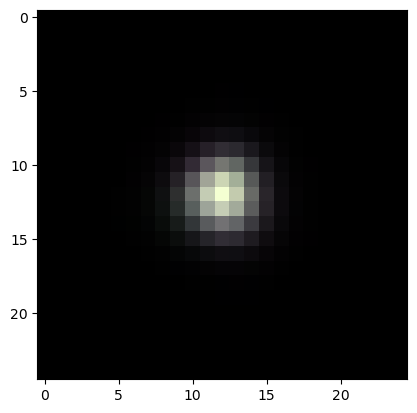

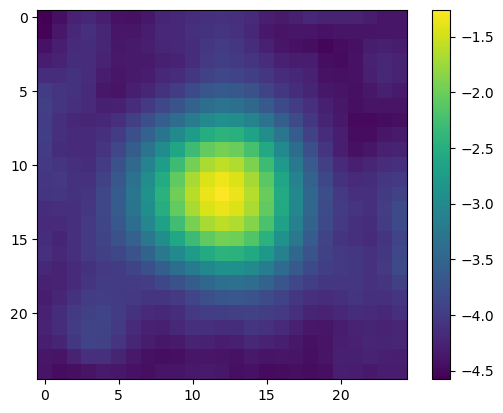

  0%|                                                     | 0/5 [03:05<?, ?it/s]


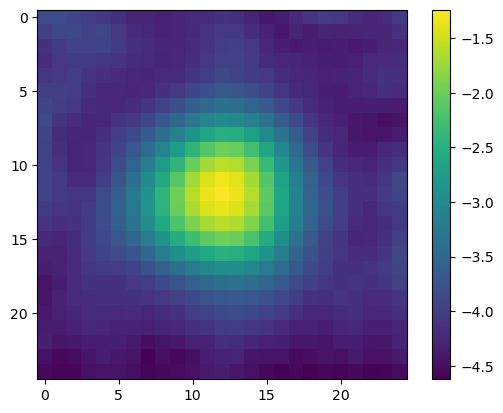

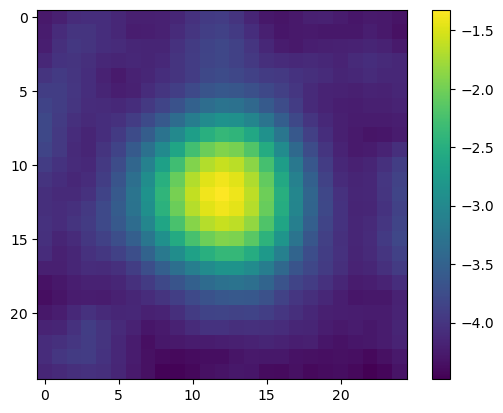

In [177]:
plt.imshow(psf/np.max(psf))
plt.show()
plt.close()

for ch in range(3):
    plt.imshow(np.log10(psf[...,ch]))
    plt.colorbar()
    plt.show()
    plt.close()  

In [190]:
def ExtractPSFs(image_set, max_imgs=None):    
    
    if max_imgs:
        selection = np.ones(len(image_set),dtype=bool)
        selection[max_imgs:] = False
    else:
        selection = None
    
    print(f'Computing image PSFs')
    with odp.ImageProcessor(nproc=16) as proc:
        # These could be saved to disk if too big
        PSFs = proc.map(get_img_psf, light_regtx, selection=selection, verbose=True)

    return PSFs

In [ ]:
PSFs = ExtractPSFs(light_regtx, max_imgs=20)

Computing image PSFs




  0%|                                                    | 0/20 [00:00<?, ?it/s]

In [ ]:
for i in range(5):
    psf = np.asarray(psfs[i])

    plt.subplot(2,2,1)
    plt.imshow(psf/np.max(psf))
    
    for ch in range(3):
        plt.subplot(2,2,ch+2)
        plt.imshow(np.log10(psf[...,ch]))
        plt.colorbar()

    plt.show()
    plt.close()

In [ ]:
from PIL import Image

def display_stf(img, blackpoint=0.01, whitepoint=1-1e-5, symmetry_sigma=0.02, stretch_factor=5, save=None, plot=True, show=True, **kwargs):
    '''Performs a GHS stretch on data normalized to a blackpoint and whitepoint by quantile.'''
    blackpoint,whitepoint = np.quantile(img,[blackpoint,whitepoint])
    med,std = np.median(img),np.std(img)
    img = np.clip(img, blackpoint, whitepoint)
    stretched = odp.ghs(img, low_point=blackpoint, high_point=whitepoint, symmetry_point=med+std*symmetry_sigma, stretch_factor=stretch_factor)
    pil_img = Image.fromarray(np.asarray(255*stretched,dtype=np.uint8))
    if save:
        pil_img.save(save, **kwargs)
    if plot:
        plt.imshow(stretched, cmap='gray')
        if show:
            plt.show()
            plt.close()
    else:
        return pil_img

odp.display_stf = display_stf

In [ ]:
from tqdm import tqdm

In [ ]:
#ImageMM algorithm, with FFTs

KAPPA = 2.0
TOL = 1e-4

from scipy.signal import fftconvolve

def conv2(x, k):
    return fftconvolve(x, k, mode='same')

def conv2_T(x, k):
    # Adjoint convolution: correlate with flipped kernel
    k_flip = np.flip(k)
    return fftconvolve(x, k_flip, mode='same')

def ImageMM(image_set, psfs, max_imgs=None, snapshots=False, display=False):
    
    def y_t(t, ch):
        return image_set[t][...,ch]

    def F_t(t, ch):
        return psfs[t][..., ch]
            
    latent_image = np.empty_like(y_t(0,slice(None)), dtype=DTYPE)
    snapshots = [[],[],[]] if snapshots else None
    
    for CH in range(3):
        
        print(f'Processing channel {CH}')
        
        # ImageMM secret sauce
        
        # the paper chose to write this as a more general matrix operation on a 1D image, which is impossible to implement
        # i'll use discrete ffts to do fast convolutions on 2d images without blowing up the memory requirements
        
        def y_F_W(t):
            # the image, in 2d instead of the 1d notation from the paper
            y = y_t(t, CH)
        
            # this image's PSF as a 2d kernel
            F = F_t(t, CH)
            
            # images may have missing data
            masked = np.logical_or(np.isnan(y), y <= 0)
            y[masked] = -1
            
            # this is assuming the variance of the signal is the signal
            # there's some overall proprtionality here, but it would (?) cancel out in the numerator and denominator
            W = np.where(masked,0,1)/y 
        
            return y,F,W
            
        # Compute num and den for update image u_k = (sum F_t^T W_t y_t) / (sum F_t^T W_t F_t x_k-1)
        # split into separate functions, as num is constant wrt k
        
        def u_k_num(t):
            y,F,W = y_F_W(t)
            return conv2_T(W * y, F)
        
        def u_k_den(t, x_guess):
            _,F,W = y_F_W(t)
            return conv2_T(W * conv2(x_guess, F), F)
        
        # for some pixel-level statistics
        y_sum = np.zeros_like(y_t(0,CH))
        norm = np.zeros_like(y_sum)
        
        for t in range(len(image_set)):
            y = y_t(t,CH)
            # images may have missing data
            masked = np.logical_or(np.isnan(y), y <= 0)
            y[masked] = -1
            y_sum += y
            norm += np.where(masked,0,1)
            if t >= max_imgs-1: break
                
        n_t = t+1
        print(f'Max-likelihood extraction on {n_t} images')
        
        # why not initialize to a naive stack?
        x_guess = y_sum/norm

        if snapshots:
            snapshots[CH].append(x_guess.copy())
        if display:
            odp.display_stf(x_guess)
        
        print(f'Precomputing u_k numerator')
        
        num = np.zeros_like(x_guess)
        pbar = tqdm(total=n_t)
        for t in range(n_t): #TODO this is fully parallelizable 
            num += u_k_num(t)
            pbar.update(1)
        pbar.close()
        
        u_prev = None
        
        for k in range(1,20): 
            
            print(f'Starting iteration {k}')
            
            den = np.zeros_like(x_guess)
            pbar = tqdm(total=n_t)
            for t in range(n_t): #TODO this is fully parallelizable 
                den += u_k_den(t, x_guess)
                pbar.update(1)
            pbar.close()
        
            den = np.maximum(den, 1e-12)
            u_k = np.clip(num / den, 1/KAPPA, KAPPA)
            print(f'Num Mean: {np.mean(num)}  Den Mean: {np.mean(den)} u_k Mean: {np.mean(u_k)}')
        
            # Check convergence of clipped update image
            if u_prev is not None:
                diff = np.mean(np.abs(u_k - u_prev))
                print(f'Err: {diff}')
                if diff > 0 and diff < TOL:
                    break
            u_prev = u_k
        
            # Multiplicative update
            x_guess *= u_k
            x_guess = np.maximum(x_guess, 0.0)
            
            if snapshots:
                snapshots[CH].append(x_guess.copy())
            if display:
                odp.display_stf(x_guess)
        
        latent_image[...,CH] = x_guess
        
    if snapshots:
        return latent_image, snapshots
    else:
        return latent_image

In [ ]:
latent_image, snapshots = ImageMM(light_regtx, PSFs, max_imgs=20, snapshots=True,  display=False)

In [ ]:
display_stf(snapshots[1][0], save='start_latent.png', plot=False)

In [ ]:
display_stf(snapshots[0][-1], save='end_latent.png', plot=False)

In [ ]:
display_stf(latent_image, save='rgb_latent.png', plot=False)

In [ ]:
# DEVELOPMENT ENDS HERE! STAY TUNED FOR MORE!